In [15]:
import astropy
import astropy.units as u
from astropy.coordinates import SkyCoord
import os
import numpy as np
import specsim.simulator
from speclite import filters
from speclite import redshift
from astropy.constants import h, c, k_B
from astropy.cosmology import Planck18
from astropy.table import Table, join
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import bed
from bed.grid import Grid, PermutationInvariant
from bed.design import ExperimentDesigner
from bed.grid import TopHat

In [3]:
def blackbody_lambda(wavelength, temperature = 5000 * u.K):
    """
    Compute the blackbody surface flux density (per unit wavelength)
    at a given wavelength and temperature.

    Args
    ----------
    wavelength : Quantity
        Wavelength(s), must have units (e.g. u.AA, u.nm, u.um).
    temperature : Quantity
        Temperature with units of Kelvin.

    Returns
    -------
    flux_density : Quantity
        Flux density (erg / s / cm² / Å), i.e., total emitted flux from the surface.
    """
    # Ensure proper units
    wavelength = wavelength.to(u.cm)
    temperature = temperature.to(u.K)

    exponent = (h.cgs * c.cgs) / (wavelength * k_B.cgs * temperature)
    F = (2 * np.pi * h.cgs * c.cgs**2) / (wavelength**5 * (np.exp(exponent.value) - 1))

    return F.to(u.erg / (u.s * u.cm**2 * u.AA))

For now we're going to unrealistically assume a perfect blackbody for our spectral energy distribution (SED) of a galaxy object so we can infer the redshift.

The luminosity of a galaxy object can be calculated from the flux emitted at its surface as:
$ L = 4 \pi R^2 F_{emitted} $. Since we measure it here on Earth (LSST telescope), the flux measured at a luminosity distance $D_L(z)$ can be calculated as:
$ L = 4 \pi D_L(z)^2 F_{measured} $ where luminosity distance depends on the cosmological parameters of the universe and redshift $z$.

It follows from these equations: $F_{measured} = (R/D_L(z))^2 F_{emitted}$.

But then we also have to account for the redshift which is stretching the wavelength of emitted photons by a factor of $1+z$.

Thus, we end up with an expression for observed flux as:

$F_{measured} = \frac{(R/D_L(z))^2}{1+z}F_{emitted}$




In [ ]:
def get_observed_flux(filter, z, R = 0.001 * u.Mpc, T = 5000 * u.K):
    """
    Calculate the observed flux of a galaxy in a given filter.
    """
    # let's assume a typical temperature for a star, eventually we can use a prior distribution on the temperature
    # get the surface flux of a "galaxy" object
    wavelengths = filters.load_filter(filter).wavelength * u.AA
    surface_flux = blackbody_lambda(wavelengths, T)
    D = Planck18.luminosity_distance(z)
    observed_flux = surface_flux * ((R/D))**2 / (1+z)

    return observed_flux, wavelengths

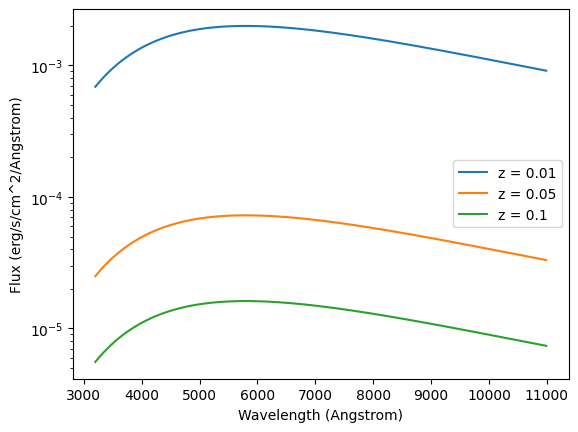

In [57]:
R = (0.5 * u.R_sun).to(u.cm) # radius of the star
D = (20 * u.pc).to(u.cm) # distance to the star
filter = "lsst2023-r" # ["lsst2023-r", "lsst2023-i", "lsst2023-z", "lsst2023-y", "lsst2023-u", "lsst2023-g"]
for z in [0.01, 0.05, 0.1]:
    observed_flux, wlen = get_observed_flux(filter, z)
    plt.plot(wlen, observed_flux, label = f"z = {z}")
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Flux (erg/s/cm^2/Angstrom)')
plt.yscale('log')
plt.legend()
plt.show()

The likelihood is going to be a Gaussian distribution where the mean is the calculated AB magnitude from speclite as a function of the distance $M_b(D)$ for each LSST filter band $b$. Then we just need a model for the photometric (image) noise in *flux*:

$\sigma_b^2(t_b) = \sigma_{sky}(t_b)^2 + \sigma_{src}(t_b)^2 + \sigma_{read}(t_b)^2$

which is a function of the exposure time $t_b$ per band $b$, and then propagate error to convert to magnitude uncertainty. The exposure time in each band is the design $d$. The detector is measuring total number of photons $N$ accumulated over time meaning the source (shot) noise $\sigma_{N, src}$ coming from the randomness of photons entering the detector depends on the source flux rate $F_b$, the telescope area $A$, and the exposure time $t_b$. Given that shot noise is Poisson distributed ($\sigma = \sqrt{N}$):

$\sigma_{N, src}(t_b) = \sqrt{F_b \times A \times t_b}$

The source flux rate can be calculated as the band-integrated source flux rate, that is the total number of photons per second per cm^2:

$F_b = \int f_\lambda(\lambda) T_b(\lambda) \lambda d\lambda$

where $f_\lambda$ is the observed spectral energy distribution (SED) from our blackbody source and $T_b$ is the dimensionless transmission curve. We scale by $\lambda$ for photon-counting detectors. Thus the units of $S_b$ are photons per unit time and area. 

We're interested in the uncertainty on the magnitude which means we need an uncertainty on the source flux $\sigma_{src}$, not the number of photons $\sigma_N$, so we convert it:

$\sigma_{src} = \frac{\sigma_{N, src}}{A \times t_b}$

In [46]:
# calculating the source uncertainty for a given filter and exposure time (units of photons^(1/2) / cm)
def source_flux_uncertainty(F_b, t, A=35000 * u.cm**2):
    """
    Calculate the source flux uncertainty for a given filter and exposure time.

    Returns:
        sigma_src: Quantity with units photons / (s cm²)
    """

    # Flux uncertainty (same units as S_b)
    sigma_src = np.sqrt(F_b / (A * t))

    return sigma_src.to(1 / (u.s * u.cm**2))


For the sky noise in flux space $\sigma_{sky}$, we need the sky brightness $m_{b, sky}$ in each band which are pre-defined values from LSST, the telescope area $A$ in units of $cm^2$, the aperture area on sky $\Omega$, the zero-point flux $f_0$ which is the photon flux for AB magnitude = 0, and the exposure time $t_b$. Since the fixed sky brightness magnitude $m_{b, sky}$ isn't confined to just the aperature, we must scale the flux result by $\Omega$ such that we're representing the noise in just that region of the observing space.

We get a flux of the sky brightness by converting the magnitude back into a flux scaled by the zero-point flux $f_0$: $F_{sky} = f_0 \times 10^{-0.4 m_{b, sky}}$.


The aperture area on sky $\Omega= \pi r^2 $ is the angular area over which you sum light from a source. The typical aperature radius is 1 arcsec.

Then the shot noise from the sky brightness is calculated in a similar way to the source noise:

$\sigma_{N, sky}(t_b) = \sqrt{F_{sky} \times \Omega \times A \times t_b}$.

Then the sky noise in flux space is: $\sigma_{sky} = \frac{\sigma_{N, sky}}{A \times t_b}$

In [47]:
# calculating the sky noise for a given filter and exposure time
def sky_flux_uncertainty(filter, t, A=35000 * u.cm**2, omega=3.14 * u.arcsec**2):
    """
    Calculate the sky noise (flux uncertainty) in a given LSST filter band.

    Args:
        filter: str, name of LSST filter (e.g., 'lsst_r')
        t_b: float or Quantity, exposure time in seconds
        A: Quantity, telescope collecting area (default: LSST ~35000 cm²)
        omega: Quantity, aperture area on the sky (default: 3.14 arcsec²)

    Returns:
        sigma_sky: Quantity, sky noise in photons / (s cm²)
                  (integrated over the bandpass — not per Å)
    """

    loaded_filter = filters.load_filter(filter)
    wlen = loaded_filter.wavelength * u.AA

    # Values for m_b,sky from table 3.2 of this paper: https://arxiv.org/pdf/0912.0201
    lsst_sky_brightness = {"lsst2023-u": 21.8, "lsst2023-g": 22.0, "lsst2023-r": 21.3, "lsst2023-i": 20.0, "lsst2023-z": 19.1, "lsst2023-y": 17.5}
    
    # Get sky brightness in AB mag/arcsec²
    m_sky = lsst_sky_brightness[filter]

    # Flat AB spectrum f_nu = 3631 Jy
    f_nu = 3631 * u.Jy
    # convert from frequency to wavelength space
    f_lambda = f_nu.to(u.erg / u.s / u.cm**2 / u.AA, equivalencies=u.spectral_density(wlen))

    hc = (h * c).to(u.erg * u.Angstrom)
    photon_flux_density = f_lambda * wlen / hc  # photons / s / cm² / Å

    # Integrate to get total photons/s/cm² for AB=0 mag over filter
    f_0 = np.trapezoid(photon_flux_density * loaded_filter(wlen), wlen)

    # Convert sky mag → photon flux per arcsec² applying the proper units
    f_sky = f_0 * 10**(-0.4 * m_sky) * (1/u.arcsec**2) # photons / s / cm² / arcsec²

    # Total sky counts over time and aperture
    N_sky = f_sky * omega
    
    return np.sqrt(N_sky / (A * t))

For the read noise in flux space $\sigma_{read}$, we need the RMS noise in electrons per pixel $\sigma_{pix, read}$ which is a constant: ~5 electrons for LSST. Then to get the total variance from read noise across pixels in the aperature, we add together the individual variances for independent noise sources (each electronic readout chain):

$\sigma_{tot, read}^2 = N_{pix} \sigma_{pix, read}^2$

Then the total standard deviation in electrons, we take the square root of this quantity.

Following the pattern from the previous steps, we want to convert this uncertainty from a count of electrons (same as photons since they're converted), so we divide by the total detector area $A$ and exposure time $t_b$.

Then the read noise in flux space is: $\sigma_{read}(t_b) = \frac{\sigma_{tot, read}}{A \times t_b}$

In [48]:
def read_flux_uncertainty(t_exp, A=35000 * u.cm**2, N_pix=25, sigma_pix=5):
    """
    Calculate the read noise flux uncertainty for a given exposure time and telescope area.

    Returns:
        sigma_read: Quantity with units electrons / (s cm²)
    """

    # Read noise (same units as S_b)
    sigma_read = np.sqrt(N_pix * sigma_pix**2) / (A * t_exp)

    return sigma_read.to(1 / (u.s * u.cm**2))

In [55]:
def total_mag_uncertainty(filter, t_exp, observed_flux):
    """
    Calculate the total noise for a given filter and exposure time.

    Args:
        filter: str, the filter used in the observation
        t: float, the exposure time in seconds
        observed_flux: float, the observed flux from the source in erg/s/cm^2/AA

    Returns:
        sigma_mag: float, the total magnitude uncertainty
    """
    loaded_filter = filters.load_filter(filter)
    hc = (h * c).to(u.erg * u.Angstrom)
    wlen = loaded_filter.wavelength * u.AA

    # Compute band-integrated photon flux rate
    F_b = np.trapezoid(observed_flux * loaded_filter(wlen) * (wlen / hc), wlen)
    print("F_b = ", F_b)

    sigma_src = source_flux_uncertainty(F_b, t_exp)
    sigma_sky = sky_flux_uncertainty(filter, t_exp)
    sigma_read = read_flux_uncertainty(t_exp)
    print("Sky noise = ", sigma_sky)
    print("Source noise = ", sigma_src) 
    print("Read noise = ", sigma_read)
    
    total_flux_uncertainty = np.sqrt(sigma_sky**2 + sigma_src**2 + sigma_read**2)

    # propagate error to magnitude
    return 1.0857 * total_flux_uncertainty / F_b

# let's assume an exposure time of 30 seconds
t_r = 30 * u.s

sigma_mag = total_mag_uncertainty("lsst2023-r", t_r, observed_flux)
print("Total magnitude uncertainty = ", sigma_mag)

F_b =  372604776611.2076 1 / (s cm2)
Sky noise =  7.75891253362266e-05 1 / (s cm2)
Source noise =  595.702687597323 1 / (s cm2)
Read noise =  2.380952380952381e-05 1 / (s cm2)
Total magnitude uncertainty =  1.7357652089341627e-09


In [58]:
# some input typical values for a star in our neighborhood (converted to cm)
t_exp = 30 * u.s
z = 0.1
filter = "lsst2023-r" # ["lsst2023-r", "lsst2023-i", "lsst2023-z", "lsst2023-y", "lsst2023-u", "lsst2023-g"]
def calculate_mag(t_exp, filter, z):
    observed_flux, wlen = get_observed_flux(filter, z)
    sigma = total_mag_uncertainty(filter, t_exp, observed_flux)
    return filters.load_filter(filter).get_ab_magnitude(observed_flux, wlen), sigma

mag_obs, mag_sigma = calculate_mag(t_exp, filter, z)
print(f"Magnitude of the stellar object ({filter}) = {mag_obs} +/- {mag_sigma}")

F_b =  3726047766.1120744 1 / (s cm2)
Sky noise =  7.75891253362266e-05 1 / (s cm2)
Source noise =  59.57026875973229 1 / (s cm2)
Read noise =  2.380952380952381e-05 1 / (s cm2)
Magnitude of the stellar object (lsst2023-r) = -9.36846763717952 +/- 1.7357652089357576e-08


The magnitude and uncertainty associated with the calculate_mag function will correspond to the mean and standard deviation parameters of the Gaussian likelihood.

The likelihood would be evaluated as $M_{b, obs}$: $\mathcal{N}(M_{b, obs}; M_b(D), \sigma_b(t_b))$ and we evaluate over our features grid for a reasonable range of magnitude values.

Let's assume a uniform prior distribution for redshifts of galaxies: $z \sim [0.01, 0.1]$. This redshift $z$ is our parameter $\theta$.

In [ ]:
designs = Grid(t_r = ...,)
features = Grid(mag_r = ...,)
parameters = Grid(D = ...)